# A. Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import math
import json

import random
np.random.seed(42)
random.seed(42)

# B. Importing Data

## 1. Data File Structure

- `data/`
  - `eeg_denoise_net/`
    - `EEG_all_epochs.mat`
    - `EEG_all_epochs.npy`
    - `EMG_all_epochs.mat`
    - `EMG_all_epochs.npy`
    - `EOG_all_epochs.mat`
    - `EOG_all_epochs.npy`

## 2. Data Information

Signal Types

The dataset contains three types of single-channel biosignal epochs:
| Signal | Description                                 | Role         |
| ------ | ------------------------------------------- | ------------ |
| EEG    | Clean electroencephalography                | Ground truth |
| EOG    | Electrooculography (eye movement artifacts) | Noise source |
| EMG    | Electromyography (muscle artifacts)         | Noise source |

Sampling Rate
- 256 Hz (default dataset)
- 512 Hz version available via G-Node repository (due to size limitations)

Dataset Size
- 4514 clean EEG epochs
- 3400 EOG epochs
- 5598 EMG epochs

Each epoch is:
- Single-channel
- Fixed-length
- Time-domain signal

In [2]:
ENV = "kaggle" # or "local"

In [3]:
if ENV == "kaggle":
    EEG = np.load("/kaggle/input/eeg-denoise-net/EEG_all_epochs.npy")
    EOG = np.load("/kaggle/input/eeg-denoise-net/EOG_all_epochs.npy")
    EMG = np.load("/kaggle/input/eeg-denoise-net/EMG_all_epochs.npy")
else:
    data_path = os.path.abspath("../../data/eeg_denoise_net/")
    print(data_path)
    
    EEG = np.load(os.path.join(data_path, "EEG_all_epochs.npy"))
    EOG = np.load(os.path.join(data_path, "EOG_all_epochs.npy"))
    EMG = np.load(os.path.join(data_path, "EMG_all_epochs.npy"))

print("EEG shape:", EEG.shape)
print("EOG shape:", EOG.shape)
print("EMG shape:", EMG.shape)

EEG shape: (4514, 512)
EOG shape: (3400, 512)
EMG shape: (5598, 512)


# C. Exploratory Data Analysis

## 1. General Data Information

In [4]:
def random_preview(signal, name, n=3, seed=None):
    if seed is not None:
        np.random.seed(seed)

    idx = np.random.choice(signal.shape[0], n, replace=False)

    plt.figure(figsize=(12, 3*n))
    for i, j in enumerate(idx):
        plt.subplot(n, 1, i+1)
        plt.plot(signal[j])
        plt.title(f"{name} – Epoch {j}")
        plt.xlabel("Time (samples)")
        plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

def min_max_stats(x, name):
    print(f"{name}:")
    print(f"  min = {x.min():.6e}")
    print(f"  max = {x.max():.6e}")
    print()

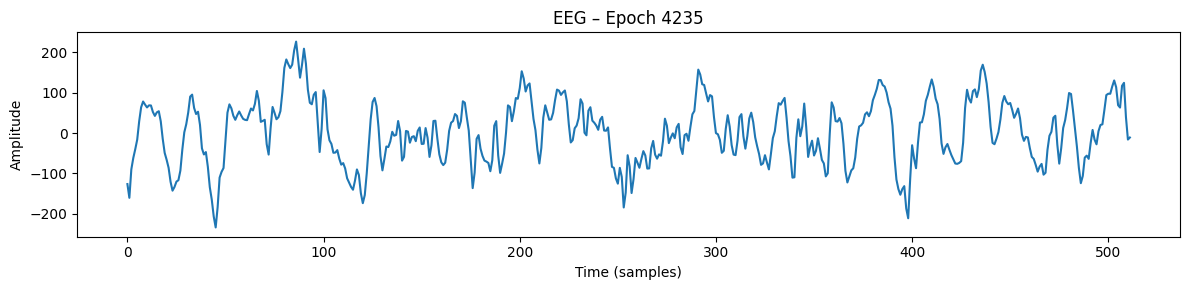

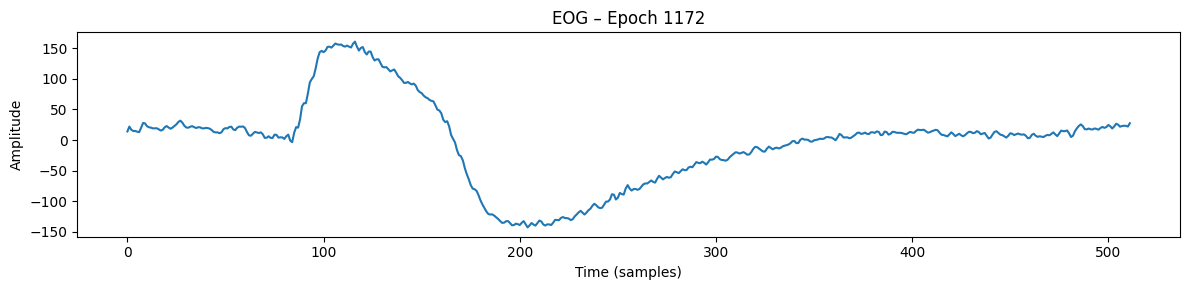

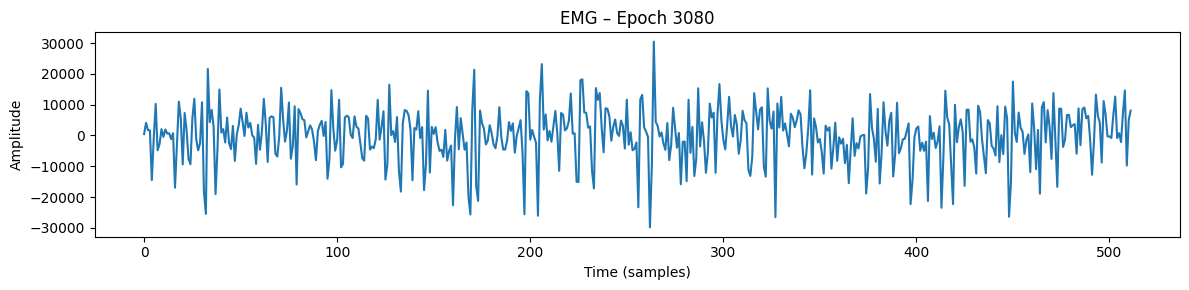

In [5]:
random_preview(EEG, "EEG", n=1)
random_preview(EOG, "EOG", n=1)
random_preview(EMG, "EMG", n=1)

In [6]:
min_max_stats(EEG, "EEG")
min_max_stats(EOG, "EOG")
min_max_stats(EMG, "EMG")

global_min = min(EEG.min(), EOG.min(), EMG.min())
global_max = max(EEG.max(), EOG.max(), EMG.max())

print("GLOBAL:")
print(f"  min = {global_min:.6e}")
print(f"  max = {global_max:.6e}")

EEG:
  min = -1.684642e+03
  max = 1.798949e+03

EOG:
  min = -1.226934e+03
  max = 1.182950e+03

EMG:
  min = -1.304140e+06
  max = 1.363045e+06

GLOBAL:
  min = -1.304140e+06
  max = 1.363045e+06


## 2. Data Usage Information

Simulated noisy EEG signals are generated by **linearly mixing clean EEG epochs with artifact signals** (EOG or EMG) according to the following formula:

### Mixing Formula

```math
y = x + \lambda \cdot n
```

where:

* **( y )** denotes the mixed (noisy) EEG signal
* **( x )** denotes the clean EEG signal
* **( n )** denotes the artifact signal (EOG or EMG)
* **( \lambda )** denotes the relative contribution (scaling factor) of the artifact

### Signal-to-Noise Ratio (SNR)

The **Signal-to-Noise Ratio (SNR)** of the noisy EEG epoch is controlled by adjusting the parameter ( \lambda ).
It is defined as:

```math
\text{SNR} = 10 \log_{10} \left( \frac{\text{RMS}(x)}{\text{RMS}(\lambda \cdot n)} \right)
```

This formulation allows the noise level to be precisely controlled in decibels (dB).


### Root Mean Square (RMS) Definition

The **Root Mean Squared (RMS)** value of a signal is defined as:

```math
\text{RMS}(g) =
\sqrt{
\frac{1}{N}
\sum_{i=1}^{N} \| g_i \|_2^2
}
```

where:

* **( N )** is the number of samples in an epoch
* **( g_i )** is the ( i^{th} ) sample of the signal


## Key Notes

According to previous studies, the signal-to-noise ratio (SNR) for EEG epochs contaminated by ocular artifacts typically ranges from **−7 dB to 2 dB**, while the SNR for EEG epochs contaminated by myogenic (EMG) artifacts ranges from **−7 dB to 4 dB**. Within these ranges, clean EEG epochs are treated as **ground truth**, and the linearly mixed epochs are regarded as **contaminated EEG signals** for training and evaluation of EEG denoising models.
* SNR is measured in **decibels (dB)** and is logarithmic
* Increasing ( \lambda ) increases noise power and **decreases SNR**




# D. Preparing Data

## 1. Mathematical formulas

In [7]:
def rms(x: np.ndarray) -> float:
    """
    Root Mean Square (RMS) of a 1D signal.
    Implements Formula (3).
    """
    x = np.asarray(x)
    return np.sqrt(np.mean(x ** 2))

def snr_db(clean: np.ndarray, noise: np.ndarray) -> float:
    """
    Compute SNR in decibels.
    Implements Formula (2).
    """
    return 10 * np.log10(rms(clean) / rms(noise))

def compute_lambda(clean: np.ndarray, noise: np.ndarray, target_snr_db: float) -> float:
    """
    Compute lambda such that the mixed signal has the desired SNR (in dB).
    """
    return rms(clean) / rms(noise) * 10 ** (-target_snr_db / 10)

## 2. Mixing Functions

In [8]:
def mix_signals(clean: np.ndarray, noise: np.ndarray, target_snr_db: float):
    """
    Mix clean signal with noise at a target SNR (dB).
    
    Returns:
        mixed_signal
        lambda_used
    """
    lam = compute_lambda(clean, noise, target_snr_db)
    mixed = clean + lam * noise
    return mixed, lam

def noisy_eeg_eog(eeg: np.ndarray, eog: np.ndarray, target_snr_db: float):
    """
    EEG contaminated by ocular artifacts (EOG).
    """
    return mix_signals(eeg, eog, target_snr_db)

def noisy_eeg_emg(eeg: np.ndarray, emg: np.ndarray, target_snr_db: float):
    """
    EEG contaminated by myogenic artifacts (EMG).
    """
    return mix_signals(eeg, emg, target_snr_db)

def noisy_eeg_eog_emg(
    eeg: np.ndarray,
    eog: np.ndarray,
    emg: np.ndarray,
    target_snr_db: float,
    eog_weight: float = 1.0,
    emg_weight: float = 1.0
):
    """
    EEG contaminated by both ocular (EOG) and myogenic (EMG) artifacts.
    
    eog_weight / emg_weight allow control of relative artifact dominance.
    """
    combined_noise = eog_weight * eog + emg_weight * emg
    return mix_signals(eeg, combined_noise, target_snr_db)


## 3. Noisy Pipeline Helper

In [9]:
def make_noisy_sample(
    noisy_signal,
    eeg_idx,
    eog_idx=None,
    emg_idx=None,
    snr_db=None,
    lambda_used=None
):
    return {
        "noisy": noisy_signal,      # np.ndarray (512,)
        "eeg_idx": eeg_idx,         # int
        "eog_idx": eog_idx,         # int or None
        "emg_idx": emg_idx,         # int or None
        "snr_db": snr_db,           # float
        "lambda": lambda_used       # float
    }

def sample_snr_uniform(low, high, rng):
    return rng.uniform(low, high)

def fixed_snr_list(snrs, rng):
    return rng.choice(snrs)


## 4. Noisy Pipeline Mixers

### a. Paper-based Mixing

In [10]:
def mix_eeg_eog_paper(
    EEG,
    EOG,
    seed=42,
    mode="random"  # "exhaustive" | "random"
):
    rng = np.random.default_rng(seed)

    eeg_train_idx = np.arange(3000)
    eeg_test_idx  = np.arange(3000, 3400)

    snr_grid = np.array([-7, -6, -5, -4, -3, -2, -1, 0, 1, 2])

    train_samples = []
    test_samples = []

    if mode == "exhaustive":
        # ---- training: 10x uniform SNR ----
        for _ in range(10):
            perm = rng.permutation(eeg_train_idx)
            for i in perm:
                snr = sample_snr_uniform(-7, 2, rng)
                noisy, lam = noisy_eeg_eog(EEG[i], EOG[i], snr)

                train_samples.append(
                    make_noisy_sample(
                        noisy,
                        eeg_idx=i,
                        eog_idx=i,
                        snr_db=snr,
                        lambda_used=lam
                    )
                )

        # ---- testing: fixed SNR grid ----
        for snr in snr_grid:
            for i in eeg_test_idx:
                noisy, lam = noisy_eeg_eog(EEG[i], EOG[i], snr)

                test_samples.append(
                    make_noisy_sample(
                        noisy,
                        eeg_idx=i,
                        eog_idx=i,
                        snr_db=snr,
                        lambda_used=lam
                    )
                )

    elif mode == "random":
        # ---- training: single pass, random SNR from grid ----
        for i in eeg_train_idx:
            snr = rng.choice(snr_grid)
            noisy, lam = noisy_eeg_eog(EEG[i], EOG[i], snr)

            train_samples.append(
                make_noisy_sample(
                    noisy,
                    eeg_idx=i,
                    eog_idx=i,
                    snr_db=snr,
                    lambda_used=lam
                )
            )

        # ---- testing ----
        for i in eeg_test_idx:
            snr = rng.choice(snr_grid)
            noisy, lam = noisy_eeg_eog(EEG[i], EOG[i], snr)

            test_samples.append(
                make_noisy_sample(
                    noisy,
                    eeg_idx=i,
                    eog_idx=i,
                    snr_db=snr,
                    lambda_used=lam
                )
            )

    else:
        raise ValueError("mode must be 'exhaustive' or 'random'")

    return train_samples, test_samples


In [11]:
def mix_eeg_emg_paper(
    EEG,
    EMG,
    seed=42,
    mode="random"  # "exhaustive" | "random"
):
    rng = np.random.default_rng(seed)

    eeg_indices = rng.choice(len(EEG), size=len(EMG), replace=True)
    emg_indices = np.arange(len(EMG))

    pairs = list(zip(eeg_indices, emg_indices))
    rng.shuffle(pairs)

    train_pairs = pairs[:5000]
    test_pairs  = pairs[5000:5598]

    snr_grid = np.array([-7, -6, -5, -4, -3, -2, -1, 0, 1, 2])

    train_samples = []
    test_samples = []

    if mode == "exhaustive":
        # ---- training: 10x ----
        for _ in range(10):
            for eeg_i, emg_i in train_pairs:
                snr = sample_snr_uniform(-7, 2, rng)
                noisy, lam = noisy_eeg_emg(EEG[eeg_i], EMG[emg_i], snr)

                train_samples.append(
                    make_noisy_sample(
                        noisy,
                        eeg_idx=eeg_i,
                        emg_idx=emg_i,
                        snr_db=snr,
                        lambda_used=lam
                    )
                )

        # ---- testing: fixed grid ----
        for snr in snr_grid:
            for eeg_i, emg_i in test_pairs:
                noisy, lam = noisy_eeg_emg(EEG[eeg_i], EMG[emg_i], snr)

                test_samples.append(
                    make_noisy_sample(
                        noisy,
                        eeg_idx=eeg_i,
                        emg_idx=emg_i,
                        snr_db=snr,
                        lambda_used=lam
                    )
                )

    elif mode == "random":
        # ---- training ----
        for eeg_i, emg_i in train_pairs:
            snr = rng.choice(snr_grid)
            noisy, lam = noisy_eeg_emg(EEG[eeg_i], EMG[emg_i], snr)

            train_samples.append(
                make_noisy_sample(
                    noisy,
                    eeg_idx=eeg_i,
                    emg_idx=emg_i,
                    snr_db=snr,
                    lambda_used=lam
                )
            )

        # ---- testing ----
        for eeg_i, emg_i in test_pairs:
            snr = rng.choice(snr_grid)
            noisy, lam = noisy_eeg_emg(EEG[eeg_i], EMG[emg_i], snr)

            test_samples.append(
                make_noisy_sample(
                    noisy,
                    eeg_idx=eeg_i,
                    emg_idx=emg_i,
                    snr_db=snr,
                    lambda_used=lam
                )
            )

    else:
        raise ValueError("mode must be 'exhaustive' or 'random'")

    return train_samples, test_samples


### b. Custom Mixing

Let:
- \( N_{EEG} \) be the number of clean EEG epochs
- \( N_{EOG} \) be the number of ocular artifact epochs
- \( N_{EMG} \) be the number of myogenic artifact epochs
- \( K \) be the number of SNR levels used

Each noisy epoch is formed by selecting:
- one EEG epoch
- one EOG epoch (or/and one EMG epoch)
- one SNR value


From that information, the number of combinations are
- EEG + EOG: N_{EEG} x N_{EOG} x K
- EEG + EMG: N_{EEG} x N_{EMG} x K
- EEG + EOG + EMG: N_{EEG} x N_{EOG} x N_{EMG} x K

Example of this is below, EEG + EOG, each using 3000 samples while having 10 SNR levels

\[
3000 x 3000 x 10 = 90,000,000
\]


In [12]:
def mix_custom(
    EEG,
    EOG=None,
    EMG=None,
    n_train=10000,
    n_test=2000,
    snr_range=(-7, 2),
    seed=42,
    eog_weight=1.0,
    emg_weight=1.0
):
    rng = np.random.default_rng(seed)

    samples = []

    def make_one():
        eeg_i = rng.integers(len(EEG))
        snr = rng.uniform(*snr_range)

        eog_i = None
        emg_i = None

        if EOG is not None and EMG is not None:
            eog_i = rng.integers(len(EOG))
            emg_i = rng.integers(len(EMG))
            noisy, lam = noisy_eeg_eog_emg(
                EEG[eeg_i],
                EOG[eog_i],
                EMG[emg_i],
                snr,
                eog_weight=eog_weight,
                emg_weight=emg_weight
            )

        elif EOG is not None:
            eog_i = rng.integers(len(EOG))
            noisy, lam = noisy_eeg_eog(EEG[eeg_i], EOG[eog_i], snr)

        elif EMG is not None:
            emg_i = rng.integers(len(EMG))
            noisy, lam = noisy_eeg_emg(EEG[eeg_i], EMG[emg_i], snr)

        else:
            raise ValueError("At least one of EOG or EMG must be provided.")

        return make_noisy_sample(
            noisy,
            eeg_idx=eeg_i,
            eog_idx=eog_i,
            emg_idx=emg_i,
            snr_db=snr,
            lambda_used=lam
        )

    for _ in range(n_train + n_test):
        samples.append(make_one())

    return samples[:n_train], samples[n_train:]

## 5. Final Preprocessing

In [13]:
def normalize_noisy_sample(sample, EEG):
    """
    Normalize one noisy EEG sample according to EEGdenoiseNet protocol.
    
    Args:
        sample: dict produced by make_noisy_sample
        EEG: clean EEG array (for ground truth lookup)
    
    Returns:
        normalized_sample (new dict)
    """
    y = sample["noisy"]
    x = EEG[sample["eeg_idx"]]

    sigma_y = np.std(y)
    if sigma_y == 0:
        raise ValueError("Standard deviation of noisy signal is zero.")

    normalized_sample = sample.copy()
    normalized_sample.update({
        "noisy_norm": y / sigma_y,     # ŷ
        "clean_norm": x / sigma_y,     # x̂
        "sigma_y": sigma_y             # stored for rescaling later
    })

    return normalized_sample

def normalize_dataset(samples, EEG):
    """
    Normalize a list of noisy EEG samples.
    
    Args:
        samples: list of noisy sample dicts
        EEG: clean EEG array
    
    Returns:
        list of normalized sample dicts
    """
    return [normalize_noisy_sample(s, EEG) for s in samples]


# E. Model Definition

## 1. GAN Architectures for EEG Denoising (WGAN Framework)

In this work, EEG denoising is formulated as a **conditional distribution-to-distribution translation problem**, mapping noisy EEG epochs to clean EEG epochs. To improve stability and avoid mode collapse commonly observed in classical GANs, we adopt the **Wasserstein GAN (WGAN)** framework.

All models operate on **single-channel, normalized EEG epochs of length 512**, following the EEGdenoiseNet preprocessing protocol.

### Why WGAN for EEG Denoising

Compared to standard GANs, WGANs offer:
- A **meaningful loss metric** (Wasserstein distance) correlated with sample quality
- **Improved training stability** on continuous signals
- Better handling of **high-frequency artifacts** (especially EMG)
- Reduced sensitivity to discriminator overfitting

This is particularly important for EEG signals, which are:
- low-amplitude
- non-Gaussian
- highly structured in time and frequency

### Conditioning Strategy

All GANs are **conditional WGANs (cWGANs)**:

- **Generator \( G \)** learns:
  \[
  G: y \rightarrow \hat{x}
  \]
  where \( y \) is a normalized noisy EEG epoch.

- **Discriminator / Critic \( D \)** receives **paired inputs**:
  - Real pair: \( (y, x) \)
  - Fake pair: \( (y, G(y)) \)

This ensures that realism is evaluated **relative to the input noise**, not in isolation.

### Architecture Variants

#### I. Convolutional WGAN (CNN-WGAN)

**Generator**
- 1D convolutional U-Net–style architecture
- Encoder–decoder with skip connections
- Residual blocks in bottleneck
- Captures local temporal dependencies and preserves waveform morphology

**Critic**
- 1D PatchGAN critic
- Evaluates realism over **local temporal segments**
- Encourages realistic short-term structure

**Use case**
- Primary baseline
- Best trade-off between stability, performance, and complexity

#### II. Multi-Scale Residual WGAN (ResCNN-WGAN)

**Generator**
- Extension of CNN-WGAN
- Bottleneck uses **multi-scale residual blocks** with kernels of different sizes (e.g., 3, 5, 7)
- Explicitly models EEG patterns across multiple temporal resolutions

**Critic**
- Same PatchGAN critic as CNN-WGAN

**Use case**
- High-fidelity denoising
- Especially effective for EMG-contaminated EEG
- GAN analogue of EEGdenoiseNet’s “complex CNN”

#### III. Fully Connected WGAN (FC-WGAN)

**Generator**
- Multi-layer perceptron mapping flattened noisy EEG → clean EEG
- Optional residual connection to preserve low-frequency structure

**Critic**
- Fully connected network operating on concatenated (y, x) vectors

**Use case**
- Ablation study
- Direct comparison to EEGdenoiseNet’s FCNN baseline
- Not expected to outperform convolutional models

### Loss Function (WGAN)

The critic is trained to approximate the **Wasserstein distance** between real and generated distributions:

```math
\mathcal{L}_D
=
\mathbb{E}_{(y,x)\sim P_{\text{data}}}
\left[ D(y, x) \right]
-
\mathbb{E}_{y\sim P(y)}
\left[ D(y, G(y)) \right]
+
\lambda_{gp} \cdot \mathrm{GP}
```

The generator loss is defined as:

```math
\mathcal{L}_G
=
-
\mathbb{E}_{y\sim P(y)}
\left[ D(y, G(y)) \right]
+
\alpha \cdot \mathcal{L}_{\text{rec}}
```

Where:

- **GP** is the gradient penalty term used in WGAN-GP to enforce the 1-Lipschitz constraint
- \( \mathcal{L}_{\text{rec}} \) is a reconstruction loss (L1 or MSE) between the generated clean EEG and the ground-truth clean EEG
- \( \alpha \) controls the trade-off between **distribution realism** and **signal fidelity**

### Normalization Compatibility

All GAN models operate on **per-epoch normalized signals**:

$$
\hat{y} = \frac{y}{\sigma_y}, \qquad
\hat{x} = \frac{x}{\sigma_y}
$$

where \( \sigma_y \) is the standard deviation of the noisy EEG epoch.

Normalization removes amplitude-based cues and ensures that the critic focuses on **signal structure** rather than absolute scale. After inference, the denoised output is rescaled by multiplying with \( \sigma_y \).

This prevents trivial discrimination based on signal scale and ensures consistent training across SNR levels.

### Summary

| Model | Generator | Critic | Purpose |
|------|----------|--------|--------|
| CNN-WGAN | Conv U-Net | PatchGAN | Primary baseline |
| ResCNN-WGAN | Multi-scale ResNet | PatchGAN | High-quality denoising |
| FC-WGAN | MLP | MLP | Ablation / comparison |

All models share the same data pipeline, SNR protocol, and evaluation metrics, enabling fair comparison.



## 2. Model Building Block Definition

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### a. Building Block Descriptions

#### ConvBlock1D

Phases
1. **1D Convolution**
    - Kernel size: 15
    - Stride: 2
    - Transformation: (B, in_ch, T_in) → (B, out_ch, T_out) 
        - B (Batch size): e.g. B = 16 means 16 independent 2-second EEG segments.
        - T (Time dimension): 512 at the beginning
    - Example
        - Input: (2,1,8) -> 1 channel each with 8 time sample
        - Target: 4 channels
        - `Conv1d(kernel_size=3, stride=2, padding=1)`
        - Output length:
            ```
            T_out = floor((T + 2p - k) / s) + 1
                  = floor((8 + 2(1) - 3) / 2) + 1 
                  = 4
            
            ```
        - With the configuration above, the filter size is: 4 arrays (because target 4 channels), each array has 3 values (because kernel size = 3)
        - The input becomes length 10 (because padding 1 adds two zeros, one in the beginning and one at the end)
        - Stride 2 signify how the kernel slides across the padded input, so for the example above, the leftmost element of the filter (e) would go
            - Padded input is length 10 -> 0..9 index
            - Kernel must stay in the padded input: e + (k - 1) ≤ T_padded - 1 -> e ≤ 7
            - So e goes 0 -> 2 -> 4 -> 6
        - Output: (2,4,4)
2. **Group Normalization**
    - Group Normalization (GN) normalizes activations within each individual sample, instead of across the batch.
    - Uses GroupNorm because GANs are unstable with BatchNorm, because
        - Assumes consistent statistics across the batch
        - EEG epochs are highly non-stationary
    - Formally for each group:
        ```math
           \hat{x} = \frac{x - \mu_{\text{group}}}{\sqrt{\sigma_{\text{group}}^2 + \epsilon}}
        ```
    - channels_per_group = num_channels / num_groups
    - Hard requirement: num_channels % num_groups == 0
    - Channels are grouped contiguously by index
3. **Activation**
    - ReLU or Leaky ReLU
    - Default: Leaky ReLU
    - Relu: Piecewise, 0 if less than 0, else x
    - Leaky Relu: Piecewise, 0.2x if less than 0, else x

| Component  | Role                    |
| ---------- | ----------------------- |
| Conv1d     | Learn temporal patterns |
| GroupNorm  | Stabilize statistics    |
| Activation | Nonlinearity            |

#### DeconvBlock1D
Phases

1. **1D Transposed Convolution**
    - Kernel size: 4
    - Stride: 2
    - Padding: 1
    - Transformation: (B, in_ch, T_in) → (B, out_ch, T_out) 
    - Purpose: temporal upsampling and signal reconstruction
    - Effect:
        - Increases time resolution by approximately ×2
        - Learns how to interpolate missing temporal samples (not a simple repeat)
    - Example
        - Input: `(2, 4, 4)` → 4 channels, 4 time samples
        - Target: 2 channels
        - `ConvTranspose1d(kernel_size=4, stride=2, padding=1)`
        - Output length formula:
            ```
            T_out = (T_in − 1) × stride − 2 × padding + kernel_size
                  = (4 − 1) × 2 − 2 + 4
                  = 8
            
            ```
        - Output: `(2, 2, 8)`
2. **Group Normalization**
    - Same behavior as in `ConvBlock1D`
    - Normalizes each sample independently across channel groups
    - Stabilizes magnitude during upsampling, preventing exploding activations
3. **Activation**
    - Default: **ReLU**
    - Encourages smooth, non-negative reconstructed signals
    - Avoids introducing high-frequency artifacts during reconstruction

| Component       | Role                  |
| --------------- | --------------------- |
| ConvTranspose1d | Upsample signal       |
| GroupNorm       | Stabilize amplitudes  |
| Activation      | Smooth reconstruction |

#### ResBlock1D
Phases

1. **First Convolution + GN + ReLU**
    - Kernel size: 7
    - Padding: 3
    - Stride: 1
    - Keeps time length unchanged
    - Extracts mid-range temporal features
2. **Second Convolution + GN**
    - Same kernel configuration
    - Refines extracted features
    - No activation yet (important for residual learning)
3. **Residual (Skip) Connection**
    - Input `x` is added to the transformed signal:
        
        ```
        y = x + F(x)
        ```
        
    - Followed by ReLU activation
    - Shape invariant:(B, ch, T) → (B, ch, T)
        
    - Purpose:
        - Preserves original signal information
        - Allows the network to learn *corrections* rather than full transformations
        - Improves gradient flow in deep networks

| Component       | Role                                   |
| --------------- | -------------------------------------- |
| Conv1d ×2       | Learn refined temporal features        |
| GroupNorm       | Stabilize intermediate representations |
| Skip connection | Preserve signal and ease optimization  |

#### MultiScaleResBlock1D
Phases

1. **Parallel Multi-Scale Convolutions**
    - Three branches operating in parallel:
        - Kernel size 3 → short-term patterns (high frequency)
        - Kernel size 5 → mid-term patterns
        - Kernel size 7 → longer temporal context (low frequency)
    - All branches preserve: (B, ch, T)

2. **Branch Fusion**
    - Outputs from all branches are summed:
        ```
        h = b3(x) + b5(x) + b7(x)
        ```
    - Followed by a `1×1` convolution:
        - Mixes channel information
        - Keeps time dimension unchanged
3. **Residual Connection**
    - Fused signal is added back to input:
        
        ```
        y = x + h
        ```
        
    - Final ReLU activation
    - Shape invariant: (B, ch, T) → (B, ch, T)
    - Interpretation:
        - Learns features at multiple temporal resolutions simultaneously
        - Particularly suitable for EEG, where artifacts and neural signals exist at different time scales

| Component           | Role                                             |
| ------------------- | ------------------------------------------------ |
| Multi-kernel Conv1d | Capture multi-scale temporal features            |
| GroupNorm           | Stabilize parallel branches                      |
| 1×1 Conv fusion     | Channel mixing and feature consolidation         |
| Residual connection | Preserve signal structure and training stability |

#### Bottleneck 

A bottleneck is the part of the network where:
- Spatial / temporal resolution is lowest
- Channel (feature) dimension is highest
- Receptive field is largest

What it does:
- Feature interaction
- Noise–signal disentanglement
- Contextual reasoning

### b. Building Block Implementation

In [15]:
class ConvBlock1D(nn.Module):
    """
    Conv1d -> BatchNorm1d -> Activation
    """
    def __init__(self, in_ch, out_ch, k=15, s=2, p=7, bias=True, act="lrelu"):
        super().__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=bias)
        self.norm = nn.BatchNorm1d(out_ch)

        if act == "lrelu":
            self.act = nn.LeakyReLU(0.2, inplace=True)
        elif act == "relu":
            self.act = nn.ReLU(inplace=True)
        else:
            raise ValueError("act must be 'lrelu' or 'relu'")

    def forward(self, x):
        return self.act(self.norm(self.conv(x)))


class DeconvBlock1D(nn.Module):
    """
    ConvTranspose1d -> BatchNorm1d -> Activation
    """
    def __init__(self, in_ch, out_ch, k=4, s=2, p=1, bias=True, act="relu"):
        super().__init__()
        self.deconv = nn.ConvTranspose1d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=bias)
        self.norm = nn.BatchNorm1d(out_ch)

        if act == "relu":
            self.act = nn.ReLU(inplace=True)
        elif act == "lrelu":
            self.act = nn.LeakyReLU(0.2, inplace=True)
        else:
            raise ValueError("act must be 'relu' or 'lrelu'")

    def forward(self, x):
        return self.act(self.norm(self.deconv(x)))


class ResBlock1D(nn.Module):
    """
    Residual block: (Conv -> BN -> ReLU) x2 + skip
    Keeps same channel count and length.
    """
    def __init__(self, ch, k=7, p=3, bias=True):
        super().__init__()
        self.c1 = nn.Conv1d(ch, ch, kernel_size=k, stride=1, padding=p, bias=bias)
        self.n1 = nn.BatchNorm1d(ch)
        self.c2 = nn.Conv1d(ch, ch, kernel_size=k, stride=1, padding=p, bias=bias)
        self.n2 = nn.BatchNorm1d(ch)

    def forward(self, x):
        h = F.relu(self.n1(self.c1(x)))
        h = self.n2(self.c2(h))
        return F.relu(x + h)
    
class MultiScaleResBlock1D(nn.Module):
    """
    Multi-scale residual block: parallel conv branches (k=3,5,7) then fuse.
    Keeps same channel count and length.
    """
    def __init__(self, ch, bias=True):
        super().__init__()

        self.b3 = nn.Sequential(
            nn.Conv1d(ch, ch, kernel_size=3, padding=1, bias=bias),
            nn.BatchNorm1d(ch),
            nn.ReLU(inplace=True),
        )
        self.b5 = nn.Sequential(
            nn.Conv1d(ch, ch, kernel_size=5, padding=2, bias=bias),
            nn.BatchNorm1d(ch),
            nn.ReLU(inplace=True),
        )
        self.b7 = nn.Sequential(
            nn.Conv1d(ch, ch, kernel_size=7, padding=3, bias=bias),
            nn.BatchNorm1d(ch),
            nn.ReLU(inplace=True),
        )

        self.fuse = nn.Sequential(
            nn.Conv1d(ch, ch, kernel_size=1, bias=bias),
            nn.BatchNorm1d(ch),
        )

    def forward(self, x):
        h = self.b3(x) + self.b5(x) + self.b7(x)
        h = self.fuse(h)
        return F.relu(x + h)



## 3. Model Definition

### a. Generators

In [16]:
# NN Generator (U-Net-ish + Res bottleneck)
class GeneratorCNNWGAN(nn.Module):
    """
    CNN U-Net-ish generator for EEG denoising (WGAN).
    Input : (B, 1, 512) noisy_norm
    Output: (B, 1, 512) clean_norm_hat
    """
    def __init__(self, base_ch=32, bottleneck_blocks=4, bias=False):
        super().__init__()

        # Encoder
        self.e1 = ConvBlock1D(1, base_ch,       k=16, s=2, p=7, bias=bias, act="lrelu")      # 512 -> 256
        self.e2 = ConvBlock1D(base_ch, base_ch*2, k=16, s=2, p=7, bias=bias, act="lrelu")    # 256 -> 128
        self.e3 = ConvBlock1D(base_ch*2, base_ch*4, k=16, s=2, p=7, bias=bias, act="lrelu")  # 128 -> 64
        self.e4 = ConvBlock1D(base_ch*4, base_ch*8, k=16, s=2, p=7, bias=bias, act="lrelu")  # 64 -> 32

        # Bottleneck
        bn_ch = base_ch * 8
        self.bottleneck = nn.Sequential(*[
            ResBlock1D(bn_ch, k=7, p=3, bias=bias) for _ in range(bottleneck_blocks)
        ])

        # Decoder (concat doubles channels)
        self.d1 = DeconvBlock1D(bn_ch, base_ch*4,   k=4, s=2, p=1, bias=bias, act="relu")     # 32 -> 64
        self.d2 = DeconvBlock1D(base_ch*8, base_ch*2, k=4, s=2, p=1,bias=bias, act="relu")   # 64 -> 128
        self.d3 = DeconvBlock1D(base_ch*4, base_ch,   k=4, s=2, p=1, bias=bias, act="relu")   # 128 -> 256
        self.d4 = DeconvBlock1D(base_ch*2, base_ch//2, k=4, s=2, p=1, bias=bias, act="relu")  # 256 -> 512

        # Head (linear output recommended for normalized signals)
        self.out = nn.Conv1d(base_ch//2, 1, kernel_size=7, stride=1, padding=3, bias=bias)

    def forward(self, y):
        # Encoder
        s1 = self.e1(y)   # (B, base, 256)
        s2 = self.e2(s1)  # (B, 2b, 128)
        s3 = self.e3(s2)  # (B, 4b, 64)
        s4 = self.e4(s3)  # (B, 8b, 32)

        # Bottleneck
        b = self.bottleneck(s4)

        # Decoder + skip connections
        d1 = self.d1(b)                  # (B, 4b, 64)
        d1 = torch.cat([d1, s3], dim=1)  # (B, 8b, 64)

        d2 = self.d2(d1)                 # (B, 2b, 128)
        d2 = torch.cat([d2, s2], dim=1)  # (B, 4b, 128)

        d3 = self.d3(d2)                 # (B, b, 256)
        d3 = torch.cat([d3, s1], dim=1)  # (B, 2b, 256)

        d4 = self.d4(d3)                 # (B, b/2, 512)

        return self.out(d4)              # (B, 1, 512)

In [17]:
# ResCNN Generator (Multi-scale bottleneck)
# This is the “complex CNN” GAN analogue: same U-Net but with multi-scale residual blocks.
class GeneratorResCNNWGAN(nn.Module):
    """
    Multi-scale ResCNN generator (WGAN).
    Same encoder/decoder as CNN generator, but bottleneck uses MultiScaleResBlock1D.
    """
    def __init__(self, base_ch=32, bottleneck_blocks=6, bias=False):
        super().__init__()

        # Encoder
        self.e1 = ConvBlock1D(1, base_ch,       k=16, s=2, p=7, bias=bias, act="lrelu")
        self.e2 = ConvBlock1D(base_ch, base_ch*2, k=16, s=2, p=7, bias=bias, act="lrelu")
        self.e3 = ConvBlock1D(base_ch*2, base_ch*4, k=16, s=2, p=7, bias=bias, act="lrelu")
        self.e4 = ConvBlock1D(base_ch*4, base_ch*8, k=16, s=2, p=7, bias=bias, act="lrelu")

        bn_ch = base_ch * 8
        self.bottleneck = nn.Sequential(*[
            MultiScaleResBlock1D(bn_ch, bias=bias) for _ in range(bottleneck_blocks)
        ])

        # Decoder
        self.d1 = DeconvBlock1D(bn_ch, base_ch*4,   k=4, s=2, p=1, bias=bias, act="relu")
        self.d2 = DeconvBlock1D(base_ch*8, base_ch*2, k=4, s=2, p=1, bias=bias, act="relu")
        self.d3 = DeconvBlock1D(base_ch*4, base_ch,   k=4, s=2, p=1, bias=bias, act="relu")
        self.d4 = DeconvBlock1D(base_ch*2, base_ch//2, k=4, s=2, p=1, bias=bias, act="relu")

        self.out = nn.Conv1d(base_ch//2, 1, kernel_size=7, stride=1, padding=3, bias=bias)

    def forward(self, y):
        s1 = self.e1(y)
        s2 = self.e2(s1)
        s3 = self.e3(s2)
        s4 = self.e4(s3)

        b = self.bottleneck(s4)

        d1 = self.d1(b)
        d1 = torch.cat([d1, s3], dim=1)

        d2 = self.d2(d1)
        d2 = torch.cat([d2, s2], dim=1)

        d3 = self.d3(d2)
        d3 = torch.cat([d3, s1], dim=1)

        d4 = self.d4(d3)

        return self.out(d4)


In [18]:
# Fully Connected Generator (FC baseline)
# Input is still (B,1,512), but internally we flatten.
class GeneratorFCWGAN(nn.Module):
    """
    Fully-connected generator baseline (WGAN).
    """
    def __init__(self, hidden=1024, use_residual=True):
        super().__init__()
        self.use_residual = use_residual

        self.fc1 = nn.Linear(512, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, 512)

    def forward(self, y):
        # y: (B,1,512) -> (B,512)
        inp = y.squeeze(1)
        h = F.leaky_relu(self.fc1(inp), 0.2, inplace=True)
        h = F.leaky_relu(self.fc2(h), 0.2, inplace=True)
        out = self.fc3(h)

        if self.use_residual:
            out = out + inp

        return out.unsqueeze(1)  # (B,1,512)


### b. Critics

In [19]:
# Patch Critic (shared by CNN/ResCNN)
class CriticPatch1D(nn.Module):
    """
    Conditional PatchGAN critic for WGAN:
      D(y, x) -> patch scores
    y,x: (B,1,512)
    output: (B,1,32)
    """
    def __init__(self, base_ch=32, bias=False):
        super().__init__()
        self.c1 = nn.Conv1d(2, base_ch, kernel_size=16, stride=2, padding=7, bias=bias)  # 512 -> 256
        self.c2 = ConvBlock1D(base_ch, base_ch*2, k=16, s=2, p=7, bias=bias, act="lrelu")    # 256 -> 128
        self.c3 = ConvBlock1D(base_ch*2, base_ch*4, k=16, s=2, p=7, bias=bias, act="lrelu")  # 128 -> 64
        self.c4 = ConvBlock1D(base_ch*4, base_ch*8, k=16, s=2, p=7, bias=bias, act="lrelu")  # 64 -> 32
        self.out = nn.Conv1d(base_ch*8, 1, kernel_size=7, stride=1, padding=3, bias=bias)   # 32 -> 32

    def forward(self, y, x):
        h = torch.cat([y, x], dim=1)  # (B,2,512)
        h = F.leaky_relu(self.c1(h), 0.2, inplace=True)
        h = self.c2(h)
        h = self.c3(h)
        h = self.c4(h)
        return self.out(h)


In [20]:
# Fully Connected Critic (for FC-WGAN)
class CriticFC(nn.Module):
    """
    Fully-connected conditional critic for FC-WGAN.
    Input pair (y,x) flattened and concatenated -> scalar score.
    """
    def __init__(self, hidden=1024, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(1024, hidden)
        self.fc2 = nn.Linear(hidden, hidden // 2)
        self.fc3 = nn.Linear(hidden // 2, 1)
        self.drop = nn.Dropout(dropout)

    def forward(self, y, x):
        # y,x: (B,1,512)
        yv = y.squeeze(1)
        xv = x.squeeze(1)
        h = torch.cat([yv, xv], dim=1)  # (B,1024)

        h = self.drop(F.leaky_relu(self.fc1(h), 0.2, inplace=True))
        h = self.drop(F.leaky_relu(self.fc2(h), 0.2, inplace=True))
        return self.fc3(h)  # (B,1)


## 4. Last Checks

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [22]:
def sanity_check_models(device="cpu"):
    G1 = GeneratorCNNWGAN().to(device)
    G2 = GeneratorResCNNWGAN().to(device)
    G3 = GeneratorFCWGAN().to(device)

    Dp = CriticPatch1D().to(device)
    Df = CriticFC().to(device)

    y = torch.randn(4, 1, 512, device=device)
    x = torch.randn(4, 1, 512, device=device)

    x1 = G1(y)
    x2 = G2(y)
    x3 = G3(y)

    print("G_CNN:", x1.shape)
    print("G_ResCNN:", x2.shape)
    print("G_FC:", x3.shape)

    print("D_patch(y,x):", Dp(y, x).shape)
    print("D_patch(y,G(y)):", Dp(y, x1).shape)
    print("D_fc(y,x):", Df(y, x).shape)

sanity_check_models(device=device)

G_CNN: torch.Size([4, 1, 512])
G_ResCNN: torch.Size([4, 1, 512])
G_FC: torch.Size([4, 1, 512])
D_patch(y,x): torch.Size([4, 1, 32])
D_patch(y,G(y)): torch.Size([4, 1, 32])
D_fc(y,x): torch.Size([4, 1])


# F. Training

## 1. Utility Functions

In [23]:
def gradient_penalty_patch(D, y, real_x, fake_x, device):
    """
    WGAN-GP for conditional PatchGAN critics.
    """
    B = real_x.size(0)
    eps = torch.rand(B, 1, 1, device=device).expand_as(real_x)

    x_hat = eps * real_x + (1 - eps) * fake_x
    x_hat.requires_grad_(True)

    d_hat = D(y, x_hat)
    grad = torch.autograd.grad(
        outputs=d_hat,
        inputs=x_hat,
        grad_outputs=torch.ones_like(d_hat),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    grad = grad.view(B, -1)
    return ((grad.norm(2, dim=1) - 1) ** 2).mean()

def gradient_penalty_fc(D, y, real_x, fake_x, device):
    """
    WGAN-GP for fully-connected conditional critic.
    """
    B = real_x.size(0)
    eps = torch.rand(B, 1, device=device)

    real = real_x.squeeze(1)
    fake = fake_x.squeeze(1)

    x_hat = eps * real + (1 - eps) * fake
    x_hat.requires_grad_(True)

    d_hat = D(y, x_hat.unsqueeze(1))
    grad = torch.autograd.grad(
        outputs=d_hat,
        inputs=x_hat,
        grad_outputs=torch.ones_like(d_hat),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    return ((grad.norm(2, dim=1) - 1) ** 2).mean()

def gradient_penalty(D, y, real_x, fake_x, device, critic_type):
    if critic_type == "patch":
        return gradient_penalty_patch(D, y, real_x, fake_x, device)
    elif critic_type == "fc":
        return gradient_penalty_fc(D, y, real_x, fake_x, device)
    else:
        raise ValueError(f"Unknown critic type: {critic_type}")

## 2. Loss Configuration

In [24]:
lambda_gp = 10.0     # WGAN-GP default
alpha_rec = 10.0     # reconstruction weight (important!)
n_critic = 5         # critic updates per generator update

## 3. Training Functions

In [25]:
def train_step_wgan(
    G, D,
    batch_samples,
    opt_G, opt_D,
    device,
    critic_type
):
    y = torch.stack([
        torch.tensor(s["noisy_norm"], dtype=torch.float32)
        for s in batch_samples
    ]).unsqueeze(1).to(device)

    x = torch.stack([
        torch.tensor(s["clean_norm"], dtype=torch.float32)
        for s in batch_samples
    ]).unsqueeze(1).to(device)

    # ---- Critic ----
    for _ in range(n_critic):
        with torch.no_grad():
            x_fake = G(y)

        d_real = D(y, x).mean()
        d_fake = D(y, x_fake).mean()

        gp = gradient_penalty(
            D, y, x, x_fake, device,
            critic_type=critic_type
        )

        loss_D = d_fake - d_real + lambda_gp * gp

        opt_D.zero_grad(set_to_none=True)
        loss_D.backward()
        opt_D.step()

    # ---- Generator ----
    x_fake = G(y)
    adv_loss = -D(y, x_fake).mean()
    rec_loss = F.l1_loss(x_fake, x)

    loss_G = adv_loss + alpha_rec * rec_loss

    opt_G.zero_grad(set_to_none=True)
    loss_G.backward()
    opt_G.step()

    return {
        "loss_D": loss_D.item(),
        "loss_G": loss_G.item(),
        "adv_loss": adv_loss.item(),
        "rec_loss": rec_loss.item()
    }

def train_wgan(
    G, D,
    train_samples,
    device,
    critic_type,
    epochs=50,
    batch_size=16,
    lr=1e-4
):
    """
    Generic WGAN-GP training loop.
    Works for CNN / ResCNN / FC depending on critic_type.
    """

    opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.0, 0.9))
    opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.0, 0.9))

    for epoch in range(1, epochs + 1):
        np.random.shuffle(train_samples)

        logs = []
        for i in range(0, len(train_samples), batch_size):
            batch = train_samples[i:i + batch_size]
            if len(batch) < batch_size:
                continue

            log = train_step_wgan(
                G, D,
                batch,
                opt_G, opt_D,
                device,
                critic_type
            )
            logs.append(log)

        # ---- epoch summary ----
        avg = {k: np.mean([l[k] for l in logs]) for k in logs[0]}
        print(
            f"[Epoch {epoch:03d}] "
            f"D: {avg['loss_D']:.3f} | "
            f"G: {avg['loss_G']:.3f} | "
            f"ADV: {avg['adv_loss']:.3f} | "
            f"REC: {avg['rec_loss']:.3f}"
        )


## 4. Data Generation

In [26]:
# 1 = EEG + EOG Paper
# 2 = EEG + EMG Paper
# 3 = Custom EEG + EOG
# 4 = Custom EEG + EMG
# else Custom EEG + EOG + EMG
DATA_MODE = 1 

In [27]:
if DATA_MODE == 1: # EEG + EOG Paper
    # --- generate noisy datasets (raw, unnormalized) ---
    train_samples, test_samples = mix_eeg_eog_paper(
        EEG=EEG,
        EOG=EOG,
        seed=42
    )

    # --- normalize according to EEGdenoiseNet protocol ---
    train_samples_norm = normalize_dataset(train_samples, EEG)
    test_samples_norm  = normalize_dataset(test_samples, EEG)
elif DATA_MODE == 2: # EEG + EMG Paper
    # --- generate noisy datasets (raw, unnormalized) ---
    train_samples, test_samples = mix_eeg_emg_paper(
        EEG=EEG,
        EMG=EMG,
        seed=42
    )

    # --- normalize ---
    train_samples_norm = normalize_dataset(train_samples, EEG)
    test_samples_norm  = normalize_dataset(test_samples, EEG)
elif DATA_MODE == 3:
    train_samples, test_samples = mix_custom(
        EEG=EEG,
        EOG=EOG,
        n_train=10000,
        n_test=2000,
        snr_range=(-7, 2),
        seed=42
    )

    train_samples_norm = normalize_dataset(train_samples, EEG)
    test_samples_norm  = normalize_dataset(test_samples, EEG)
elif DATA_MODE == 4:
    train_samples, test_samples = mix_custom(
        EEG=EEG,
        EMG=EMG,
        n_train=10000,
        n_test=2000,
        snr_range=(-7, 2),
        seed=42
    )

    train_samples_norm = normalize_dataset(train_samples, EEG)
    test_samples_norm  = normalize_dataset(test_samples, EEG)

else:
    train_samples, test_samples = mix_custom(
        EEG=EEG,
        EOG=EOG,
        EMG=EMG,
        n_train=10000,
        n_test=2000,
        snr_range=(-7, 2),
        seed=42,
        eog_weight=1.0,
        emg_weight=1.0
    )

    train_samples_norm = normalize_dataset(train_samples, EEG)
    test_samples_norm  = normalize_dataset(test_samples, EEG)


In [28]:
print(len(train_samples_norm))
print(len(test_samples_norm))

3000
400


## 5. Model Switch

In [29]:
USE_CNN     = True
USE_RESCNN  = True
USE_FC      = False  

assert sum([USE_CNN, USE_RESCNN, USE_FC]) >= 1, "At least one model must be enabled"

In [30]:
def build_model(model_name, device):
    """
    Returns (Generator, Critic, critic_type)
    """
    if model_name == "cnn":
        G = GeneratorCNNWGAN().to(device)
        D = CriticPatch1D().to(device)
        return G, D, "patch"

    elif model_name == "rescnn":
        G = GeneratorResCNNWGAN().to(device)
        D = CriticPatch1D().to(device)
        return G, D, "patch"

    elif model_name == "fc":
        G = GeneratorFCWGAN().to(device)
        D = CriticFC().to(device)
        return G, D, "fc"

    else:
        raise ValueError(f"Unknown model: {model_name}")


In [31]:
MODELS = []

if USE_CNN:
    MODELS.append("cnn")

if USE_RESCNN:
    MODELS.append("rescnn")

if USE_FC:
    MODELS.append("fc")

## 6. Execution

In [32]:
import os
os.makedirs("checkpoints", exist_ok=True)
from datetime import datetime

SAVE_MODELS = True
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

In [33]:
EPOCHS = 50
BATCH_SIZE = 16
LR = 1e-4

In [34]:
trained_models = {}

for model_name in MODELS:
    print("\n" + "=" * 80)
    print(f"Training model: {model_name.upper()}")
    print("=" * 80)

    # ---- build model ----
    G, D, critic_type = build_model(model_name, device)

    # ---- parameter count ----
    gen_params = sum(p.numel() for p in G.parameters())
    disc_params = sum(p.numel() for p in D.parameters())

    print(f"Generator parameters: {gen_params:,}")
    print(f"Critic parameters:    {disc_params:,}")
    print(f"Critic type:          {critic_type}")

    # ---- train ----
    train_wgan(
        G,
        D,
        train_samples_norm,
        device,
        critic_type,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        lr=LR
    )

    trained_models[model_name] = {
        'G': G,
        'D': D,
        'critic_type': critic_type
    }

    if SAVE_MODELS:
        torch.save(G.state_dict(), f"checkpoints/{model_name}_G_{TIMESTAMP}.pth")
        torch.save(D.state_dict(), f"checkpoints/{model_name}_D_{TIMESTAMP}.pth")



Training model: CNN
Generator parameters: 4,581,392
Critic parameters:    691,840
Critic type:          patch
[Epoch 001] D: -0.004 | G: 2.832 | ADV: 0.507 | REC: 0.232
[Epoch 002] D: -0.007 | G: 2.810 | ADV: 1.159 | REC: 0.165
[Epoch 003] D: -0.011 | G: 2.672 | ADV: 1.184 | REC: 0.149
[Epoch 004] D: -0.015 | G: 2.380 | ADV: 1.008 | REC: 0.137
[Epoch 005] D: -0.012 | G: 2.041 | ADV: 0.778 | REC: 0.126
[Epoch 006] D: -0.009 | G: 1.749 | ADV: 0.578 | REC: 0.117
[Epoch 007] D: -0.008 | G: 1.588 | ADV: 0.496 | REC: 0.109
[Epoch 008] D: -0.007 | G: 1.425 | ADV: 0.391 | REC: 0.103
[Epoch 009] D: -0.005 | G: 1.302 | ADV: 0.331 | REC: 0.097
[Epoch 010] D: -0.004 | G: 1.183 | ADV: 0.259 | REC: 0.092
[Epoch 011] D: -0.003 | G: 1.102 | ADV: 0.213 | REC: 0.089
[Epoch 012] D: -0.003 | G: 1.074 | ADV: 0.222 | REC: 0.085
[Epoch 013] D: -0.003 | G: 0.986 | ADV: 0.166 | REC: 0.082
[Epoch 014] D: -0.001 | G: 0.982 | ADV: 0.201 | REC: 0.078
[Epoch 015] D: -0.001 | G: 0.944 | ADV: 0.181 | REC: 0.076
[Epo

# G. Evaluation

## 1. Utility Functions

### a. Metrics

#### RRMSE — Relative Root Mean Square Error

RRMSE measures how far the denoised signal is from the clean signal, relative to the energy of the clean signal.
```math
\text{RRMSE} =

\frac{\sqrt{\mathbb{E}\left[(\hat{x} - x)^2\right]}}

{\sqrt{\mathbb{E}\left[x^2\right]}}
```

Where:
- ( x ) = clean EEG (ground truth)
- ( \hat{x} ) = denoised EEG (model output)


What it tells
- Measures **amplitude + waveform error**
- Normalized → comparable across signals and SNRs
- Penalizes:
    - wrong amplitudes
    - phase mismatch
    - residual noise

| RRMSE value   | Meaning                |
| ------------- | ---------------------- |
| **0.0**       | Perfect reconstruction |
| **< 0.3**     | Very good denoising    |
| **0.3 – 0.5** | Acceptable             |
| **> 0.5**     | Poor reconstruction    |

#### ACC — Correlation Coefficient (often called CC)
ACC measures **how similar the *shape* of the denoised signal is to the clean signal**, independent of scale.

Mathematically (Pearson correlation):
```math
\text{ACC} =

\frac{\sum (\hat{x} - \bar{\hat{x}})(x - \bar{x})}

{\sqrt{\sum (\hat{x} - \bar{\hat{x}})^2}

\sqrt{\sum (x - \bar{x})^2}}
```

What it tells you
- Measures **waveform similarity**
- Insensitive to:
    - absolute amplitude scaling
    - DC offset
- Sensitive to:
    - phase alignment
    - temporal structure

| ACC value     | Meaning                |
| ------------- | ---------------------- |
| **1.0**       | Perfect waveform match |
| **> 0.9**     | Excellent              |
| **0.8 – 0.9** | Good                   |
| **< 0.7**     | Poor                   |

#### Both Metrics as Complement
| Metric | Captures                     | Misses           |
| ------ | ---------------------------- | ---------------- |
| RRMSE  | Absolute error, noise energy | Shape similarity |
| ACC    | Shape / phase                | Amplitude errors |

Example:
- A signal can have **low RRMSE** but poor shape → oversmoothing
- A signal can have **high ACC** but wrong amplitude → scaling issues

GANs often:
- improve **ACC** (better structure)
- sometimes slightly worsen **RRMSE**

In [35]:
def rrmse(x_hat, x):
    return torch.sqrt(torch.mean((x_hat - x) ** 2)) / torch.sqrt(torch.mean(x ** 2))


def corrcoef(x_hat, x):
    x_hat = x_hat - x_hat.mean()
    x = x - x.mean()
    return torch.sum(x_hat * x) / (
        torch.sqrt(torch.sum(x_hat ** 2)) * torch.sqrt(torch.sum(x ** 2)) + 1e-8
    )


### b. Evaluation Loop

In [36]:
@torch.no_grad()
def evaluate_wgan(
    G,
    test_samples,
    device
):
    G.eval()

    rrmse_list = []
    corr_list = []

    for s in test_samples:
        y = torch.tensor(s["noisy_norm"], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        x = torch.tensor(s["clean_norm"], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        x_hat = G(y)

        rrmse_list.append(rrmse(x_hat, x).item())
        corr_list.append(corrcoef(x_hat, x).item())

    G.train()

    return {
        "RRMSE": float(np.mean(rrmse_list)),
        "ACC": float(np.mean(corr_list))
    }


### c. Training Visual Sanity Check

In [37]:
@torch.no_grad()
def plot_example(G, sample, device):
    y = torch.tensor(sample["noisy_norm"], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    x = torch.tensor(sample["clean_norm"], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    x_hat = G(y)

    # rescale back to original amplitude
    sigma = sample["sigma_y"]
    y_plot = y.cpu().numpy().squeeze() * sigma
    x_plot = x.cpu().numpy().squeeze() * sigma
    x_hat_plot = x_hat.cpu().numpy().squeeze() * sigma

    plt.figure(figsize=(12,4))
    plt.plot(y_plot, label="Noisy EEG", alpha=0.5)
    plt.plot(x_plot, label="Clean EEG", linewidth=2)
    plt.plot(x_hat_plot, label="Denoised (GAN)", linewidth=2)
    plt.legend()
    plt.title(f"SNR = {sample['snr_db']:.2f} dB")
    plt.show()

@torch.no_grad()
def plot_examples_grid(G, samples, device, n_examples=20, n_cols=4):
    """
    Plot multiple denoising examples in a grid.
    
    Args:
        G: trained generator
        samples: list of normalized samples (test_samples_norm)
        device: torch device
        n_examples: number of examples to plot
        n_cols: number of columns in grid
    """
    G.eval()

    n_rows = math.ceil(n_examples / n_cols)
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4 * n_cols, 2.5 * n_rows),
        sharex=True,
        sharey=True
    )

    axes = axes.flatten()

    for i in range(n_examples):
        s = samples[i]

        y = torch.tensor(s["noisy_norm"], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        x = torch.tensor(s["clean_norm"], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        x_hat = G(y)

        sigma = s["sigma_y"]
        y_plot = y.cpu().numpy().squeeze() * sigma
        x_plot = x.cpu().numpy().squeeze() * sigma
        x_hat_plot = x_hat.cpu().numpy().squeeze() * sigma

        ax = axes[i]
        ax.plot(y_plot, color="gray", alpha=0.5, label="Noisy")
        ax.plot(x_plot, color="black", linewidth=1.5, label="Clean")
        ax.plot(x_hat_plot, color="tab:blue", linewidth=1.5, label="Denoised")

        ax.set_title(f"SNR = {s['snr_db']:.1f} dB", fontsize=9)
        ax.tick_params(labelsize=8)

    # turn off unused subplots
    for j in range(n_examples, len(axes)):
        axes[j].axis("off")

    # single legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=3, fontsize=10)

    fig.suptitle("EEG Denoising Examples (CNN-WGAN)", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    G.train()


## 3. Execution


Evaluating model: CNN
Evaluation results:
RRMSE: 0.4327
ACC: 0.8943


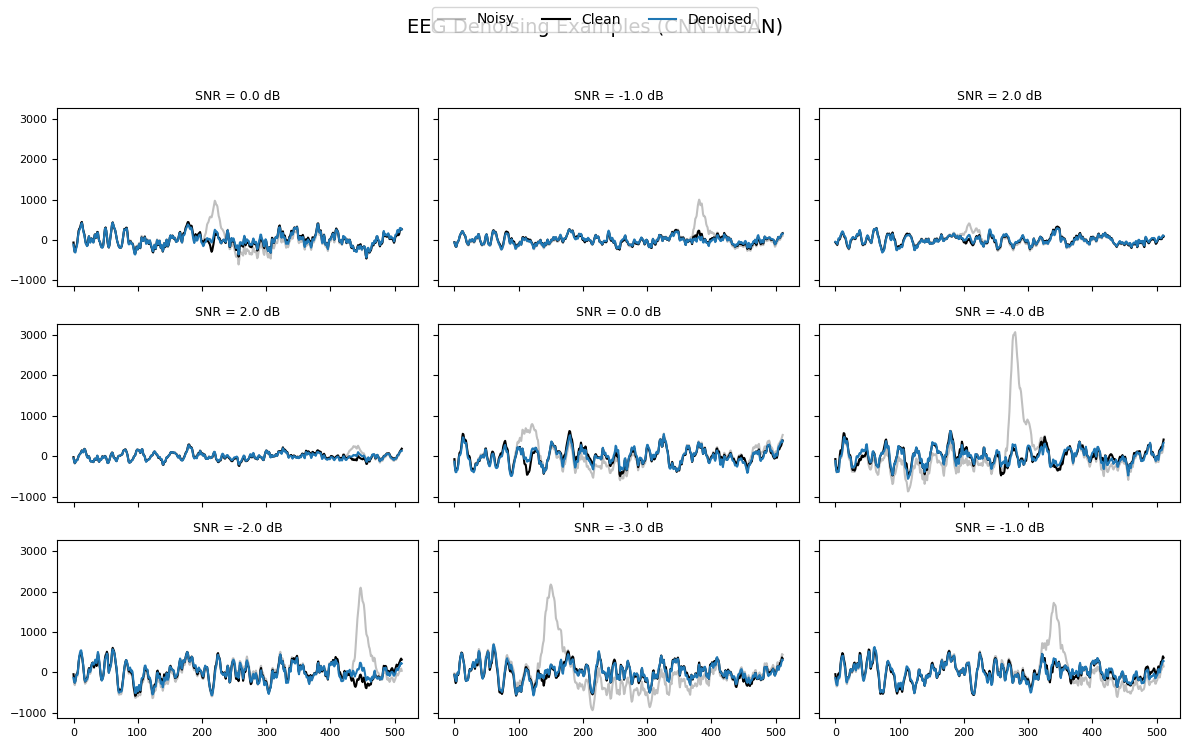


Evaluating model: RESCNN
Evaluation results:
RRMSE: 0.4322
ACC: 0.8949


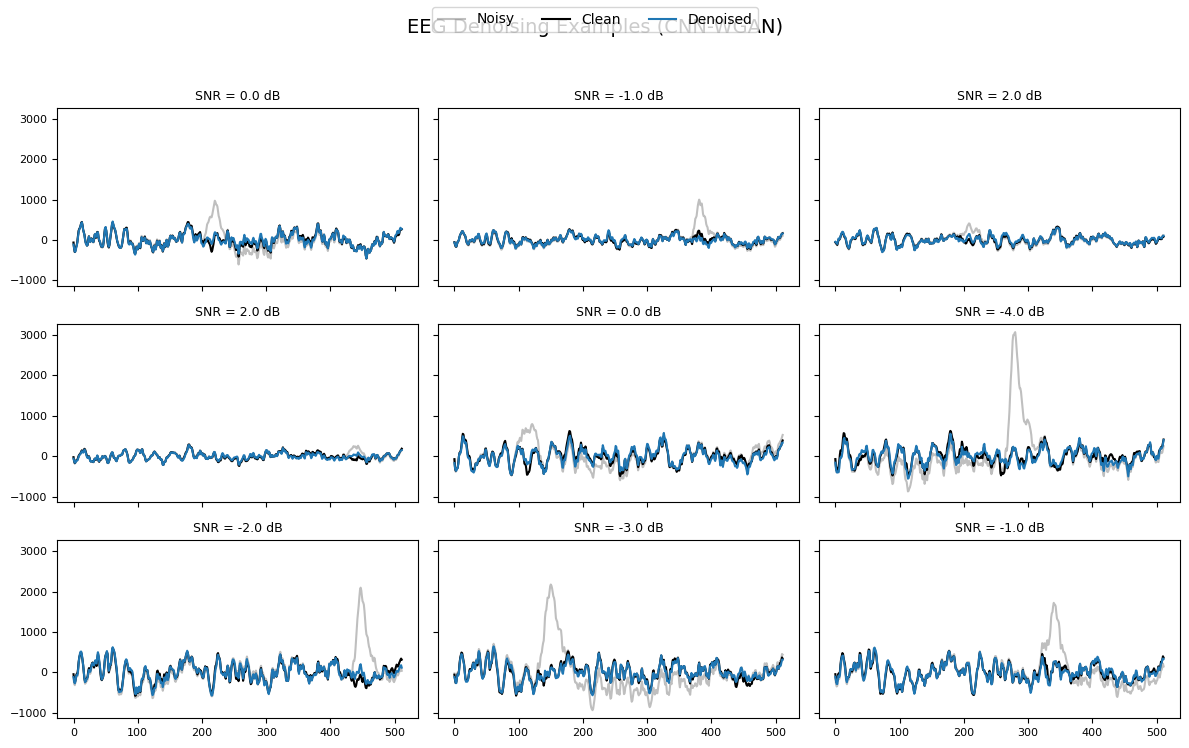

In [38]:
all_metrics = {}

for model_name in MODELS:
    print("\n" + "=" * 80)
    print(f"Evaluating model: {model_name.upper()}")
    print("=" * 80)

    # ---- rebuild model ----
    G = trained_models[model_name]['G']

    if SAVE_MODELS:
        G.load_state_dict(torch.load(f"checkpoints/{model_name}_G_{TIMESTAMP}.pth"))

    # ---- metrics ----
    metrics = evaluate_wgan(
        G,
        test_samples_norm,
        device
    )

    all_metrics[model_name] = metrics

    print("Evaluation results:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    # ---- qualitative plots ----
    plot_examples_grid(
        G,
        test_samples_norm,
        device,
        n_examples=9,
        n_cols=3
    )

## H. Saving Models